In [1]:
%matplotlib notebook
# %matplotlib tk

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import multiprocessing

from ipywidgets import widgets

import skimage
from skimage import io
from skimage.viewer import ImageViewer


# matplotlib.rcParams['toolbar'] = 'None'



In [2]:
img = io.imread(f'images/cat03.jpg')
img = skimage.transform.rescale(img, 0.1)
print(img.shape)
img[:2]

/home/rainsong/miniconda3/envs/cg/lib/python3.7/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/home/rainsong/miniconda3/envs/cg/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/rainsong/miniconda3/envs/cg/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(340, 226, 3)


array([[[0.21768156, 0.20201264, 0.17651376],
        [0.21365333, 0.19404548, 0.17051607],
        [0.23117872, 0.21157087, 0.18804146],
        ...,
        [0.31090455, 0.29913985, 0.26587347],
        [0.29024517, 0.27848047, 0.25102949],
        [0.30702279, 0.29330598, 0.26195078]],

       [[0.22126578, 0.20559686, 0.18009799],
        [0.2265698 , 0.20696196, 0.18343255],
        [0.23551255, 0.21590471, 0.19237529],
        ...,
        [0.31289106, 0.29720479, 0.26191067],
        [0.30127007, 0.28950536, 0.26205438],
        [0.27747119, 0.26375438, 0.23239918]]])

<IPython.core.display.Javascript object>


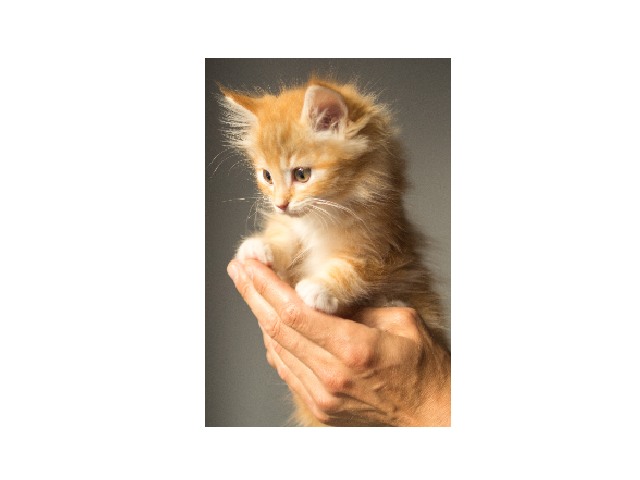

In [3]:
# viewer = ImageViewer(img)
# viewer.show()
f, axarr = plt.subplots(1,1)
axarr.axis('off')
axarr.imshow(img)

<IPython.core.display.Javascript object>


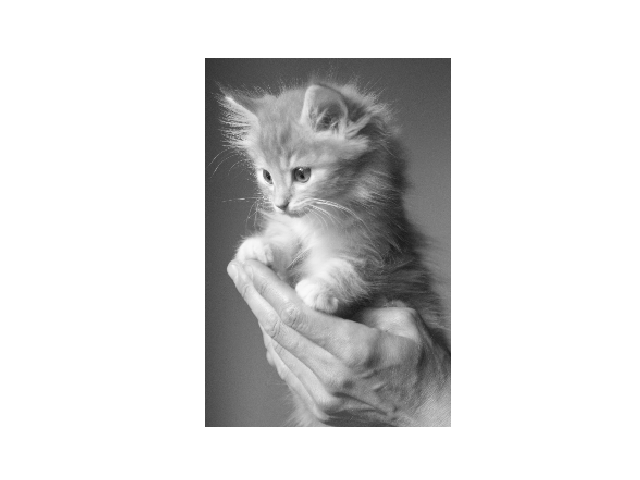

In [4]:
gray_image = img.copy()

y_, x_, _ = gray_image.shape
for x in range(x_):
    for y in range(y_):
        gray = np.mean(gray_image[y, x])
        gray_image[y, x] = gray

f, axarr = plt.subplots(1,1)
axarr.axis('off')
axarr.imshow(gray_image)

In [5]:
def get_histogram(image):
    #Image is gray, so take only red pixels
    image = image[:, :, 0]
    # Transform image to 1 dimension array
    return [pix for col in image for pix in col]



<IPython.core.display.Javascript object>


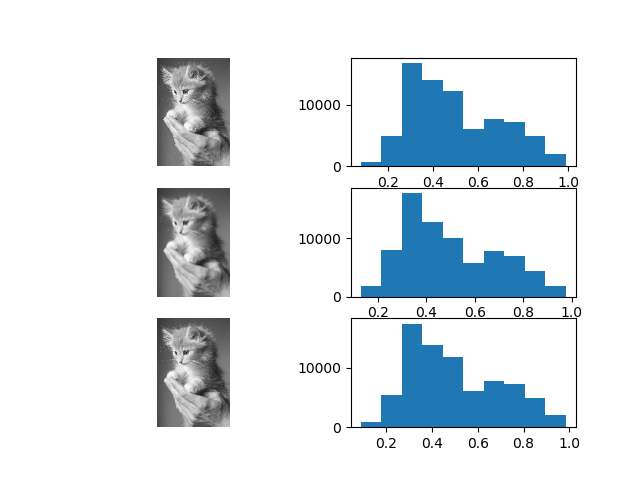

(array([  809.,  5370., 17346., 13708., 11776.,  5985.,  7717.,  7198.,
         4905.,  2026.]),
 array([0.0891258 , 0.17864459, 0.26816338, 0.35768217, 0.44720097,
        0.53671976, 0.62623855, 0.71575735, 0.80527614, 0.89479493,
        0.98431373]),
 <a list of 10 Patch objects>)

In [6]:
im = gray_image.copy()

x_max, y_max, _ = im.shape

def get_neighborhood(x_, y_, size):
    for x in range(x_ - size, x_ + size):
        for y in range(y_ - size, y_ + size):
            if x < 0 or y < 0 or x >= (x_max - 1) or y >= (y_max -1):
                continue
            yield im[x, y]

def get_mean(x, y, size):
    g = 0
    count = 0
    for px in get_neighborhood(x, y, size):
        g += px[0]
        count += 1
    return g / count

def get_median(x, y, size):
    neighs = list(get_neighborhood(x, y, size))
    np.sort(neighs)
    mid = len(neighs) // 2
    if len(neighs) % 2 == 0:
        return (neighs[mid] + neighs[mid + 1]) / 2
    return neighs[mid]

def apply_filter(fn):
    new_image = im.copy()
    for x in range(0, x_max):
        for y in range(0, y_max):
            new_image[x, y] = fn(x, y)
    return new_image
        
f, axarr = plt.subplots(3, 2)
for ax in axarr[:, 0]: ax.axis('off')

mean_filtered = apply_filter(lambda x, y: get_mean(x, y, size=2))
median_filtered = apply_filter(lambda x, y: get_median(x, y, size=2))

axarr[0][0].imshow(gray_image)
axarr[0][1].hist(get_histogram(gray_image))

axarr[1][0].imshow(mean_filtered)
axarr[1][1].hist(get_histogram(mean_filtered))

axarr[2][0].imshow(median_filtered)
axarr[2][1].hist(get_histogram(median_filtered))


<IPython.core.display.Javascript object>


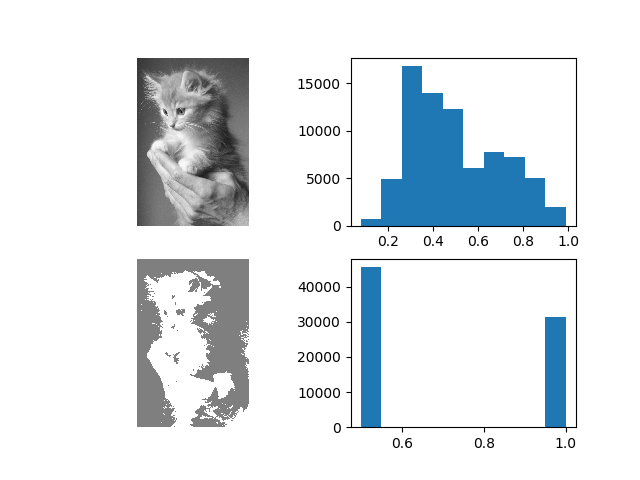

(array([45567.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 31273.]),
 array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 10 Patch objects>)

In [16]:
im = gray_image.copy()

x_max, y_max, _ = im.shape

def quantization(x, y, quantiles=4):
    MAX_PIXEL_VALUE = 1
    step = MAX_PIXEL_VALUE / quantiles
    
    px_value = im[x, y][0]
    
    for i in range(1, quantiles + 1):
        if step * i >= px_value:
            if(px_value - step * i < px_value - step * (i - 1)):
                return step * i # Round up
            return step * (i - 1) # Round down

    return 1 # Should never happen

def apply_filter(fn):
    new_image = im.copy()
    for x in range(0, x_max):
        for y in range(0, y_max):
            new_image[x, y] = fn(x, y)
    return new_image
        
quantization_filtered = apply_filter(lambda x, y: quantization(x, y, quantiles=2))

f, axarr = plt.subplots(2, 2)
for ax in axarr[:, 0]: ax.axis('off')

axarr[0][0].imshow(gray_image)
axarr[0][1].hist(get_histogram(gray_image))

axarr[1][0].imshow(quantization_filtered)
axarr[1][1].hist(get_histogram(quantization_filtered))

<IPython.core.display.Javascript object>


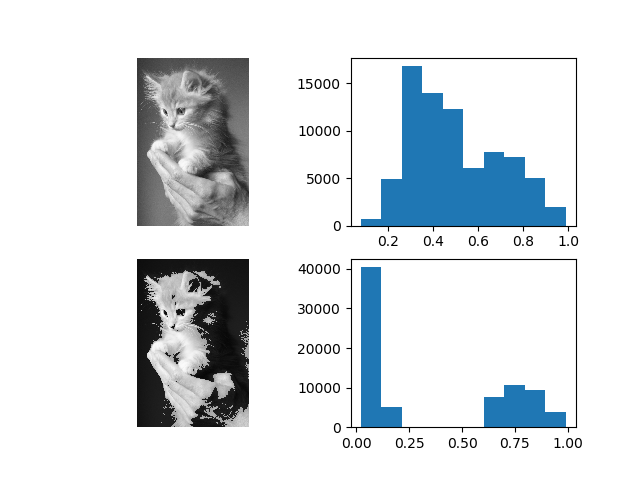

(array([40416.,  5151.,     0.,     0.,     0.,     0.,  7544., 10735.,
         9274.,  3720.]),
 array([0.02039635, 0.11747206, 0.21454776, 0.31162347, 0.40869917,
        0.50577488, 0.60285058, 0.69992629, 0.79700199, 0.8940777 ,
        0.9911534 ]),
 <a list of 10 Patch objects>)

In [42]:
im = gray_image.copy()

x_max, y_max, _ = im.shape

def splitting(x, y, threshold_min=.25, threshold_max=.75):
    MAX_PIXEL_VALUE = 1
    px_value = im[x, y][0]
    
    threshold_mean = (threshold_min + threshold_max) / 2
    
    if px_value < threshold_mean:
        return px_value * (threshold_min) # Fit to bottom sector

    return threshold_min + px_value * (1 - threshold_min) # Fit and shift to upper sector

def apply_filter(fn):
    new_image = im.copy()
    for x in range(0, x_max):
        for y in range(0, y_max):
            new_image[x, y] = fn(x, y)
    return new_image
        
splitting_filtered = apply_filter(lambda x, y: splitting(x, y, threshold_min=.25, threshold_max=.75))

f, axarr = plt.subplots(2, 2)
for ax in axarr[:, 0]: ax.axis('off')

axarr[0][0].imshow(gray_image)
axarr[0][1].hist(get_histogram(gray_image))

axarr[1][0].imshow(splitting_filtered)
axarr[1][1].hist(get_histogram(splitting_filtered))

In [50]:
im = gray_image.copy()

x_max, y_max, _ = im.shape

def equalize():
    new_image = im.copy()
    
    desired_pixels = (x_max * y_max) / 255
    
    for x in range(0, x_max):
        for y in range(0, y_max):
#             new_image[x, y] = fn(x, y)
        pass
    return new_image
        
splitting_filtered = equalize()

f, axarr = plt.subplots(2, 2)
for ax in axarr[:, 0]: ax.axis('off')

axarr[0][0].imshow(gray_image)
axarr[0][1].hist(get_histogram(gray_image))

axarr[1][0].imshow(splitting_filtered)
axarr[1][1].hist(get_histogram(splitting_filtered))

IndentationError: expected an indented block (<ipython-input-50-1c27f3ef77e1>, line 13)